In [559]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist,cdist, squareform
import scipy


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [560]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)*2*dist
        res+=dist**2              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient
#TODO ojoo cambie para la DISTANCIA AL CUADRADO!! 



#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        res+=dist              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient



#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient




Un fermat que paralieliza, sino es una tortuga. Idem euclidea

In [561]:
           
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad_fast(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    
    start_euclid_dist,start_ind=tree.query(initialData,k=1)
    idx=start_ind[:,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query(real_x,k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
    
    dist=([ [fermat_distances[idx[j],end_ind[j,i]]+end_euclid_dist[j,i] for i in range(end_euclid_dist.shape[1])] for j in range(end_euclid_dist.shape[0])])
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim=[[ fermat_distances[idx[j],end_ind[j,i]] for i in range(end_ind.shape[1])] for j in range(end_ind.shape[0])]  
    minim=np.argmin(minim,axis=1)
    
    grad_idx=[end_ind[j,minim[j]] for j in range(end_ind.shape[0])]
        
    distances=dist+start_euclid_dist[:,0]
    distances=distances.reshape(-1,1)
    
              
    q=data[grad_idx,:] 
    aux=alpha*(np.linalg.norm(q-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    local_grad=aux*(real_x-q)*2*distances
    gradient=local_grad.flatten()
    res=np.linalg.norm(distances)**2   
    return res,gradient

def euclidean_cost_fast(x,initialData):
    assert(initialData.shape[0]*initialData.shape[1]==len(x))
    real_x=x.reshape(-1,initialData.shape[1])
    res=np.linalg.norm(np.linalg.norm(initialData-real_x,axis=1))**2
    gradient=2*(real_x-initialData).flatten()
    return res,gradient

Probamos que ande rapido

In [562]:
xx=np.random.random(samples.shape).flatten()

In [563]:
%%time
p,o=fermat_cost_cuad(xx,samples,dimension,f_dist,tree,data,k,alpha)

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 203 ms


In [564]:
%%time
pp,oo=fermat_cost_cuad_fast(xx,samples,dimension,f_dist,tree,data,k,alpha)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.6 ms


In [565]:
print(np.abs(pp-p)<1e-9,np.alltrue(np.abs(oo-o)<1e-15))

True True


In [566]:
%%time
pp,oo=euclidean_cost(xx,samples)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 17.5 ms


In [567]:
%%time
p,o=euclidean_cost_fast(xx,samples)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 627 µs


In [568]:
print(np.abs(pp-p)<1e-10,np.alltrue(np.abs(oo-o)<1e-15))

True True


Creo funciones del algoritmo propuesto por Tabak, Zhao, Triglia

In [569]:
#ARMO LA MATRIZ C    

#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C


#VERSION DONDE Z ES CATEGORICO, SON ETIQUETAS, z es vector columna
def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

In [570]:
#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y,h):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )
    
    
#idem pero en el lugar ij esta el gradiente    
def grad_matrix_y(y,h):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res


def kernel_matrix_y_centros(y,centros,h):
    pairwise_dists = cdist(y,centros, 'euclidean')
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )

In [571]:
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,C,cost): 
    return  cost+ landa * (kernel_matrix.flatten() @ C.flatten())
#el lagrangiano es: sum_i[ cost(x_i,y_i)+ sum_k[landa*kernel(y_i,y_k)*C_il]   ]
    
    
    
    
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux

def fgrad_fast(y,grad_matrix,C): 
    dimension=y.shape[1]
    local_grad=np.zeros((y.shape[0],dimension))
    for d in range (dimension):
        local_grad[:,d]=np.sum(C[:,:]*grad_matrix[:,:,d].T,axis=0)
    return local_grad.flatten()


# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad

In [572]:
#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

Hago ahora una función que corra el algoritmo!

In [588]:
def barycenter(yinitial,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,categorical=True,b=1,callback=True):
    h_adapt=False
    if h==-1:
        h_adapt=True
    
    y=yinitial
    if categorical: 
        C=armar_C_categorico(z)
    else: 
        armar_C(z,b)
    landa=landa0
    learningrate=learningrate0
    n=0

    while (n<n_iter):
        if h_adapt:
            h=np.std(y)*1.06*(y.shape[0]**(-1/5))/1.5
            
        learningrate=min(learningrate*2.01,learningrate0)

        cost,cost_grad=cost_function(y.flatten(),samples)
        grad_matrix=grad_matrix_y(y,h)
        f_grad=fgrad_fast(y,grad_matrix,C)
        
        
        beta=landa*beta_adapt
        landamin=beta-landamin_actualizacion(cost_grad,f_grad)
        if(landamin>landa and landamin<landamax): 
            landa=landamin
        elif(landamin>landamax): 
            landa=landamax


        gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
        yviejo=y
        costviejo=cost


        while(True):
            y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
            
            kernel_matrix_nuevo=kernel_matrix_y(y,h) 
            cost,cost_grad=cost_function(y.flatten(),samples)
            kernel_matrix_viejo=kernel_matrix_y_centros(y,yviejo,h)
            
            lag_nuevo=lagrangiano(landa,kernel_matrix_nuevo,C,cost)
            lag_viejo=lagrangiano(landa,kernel_matrix_viejo,C,costviejo)
            
            if(lag_nuevo<=lag_viejo): 
                break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
            learningrate=learningrate/2             
        
        paso=learningrate*np.linalg.norm(gradienteLagrangiano)
        if callback: print("it: "+str(n)+", paso: "+str(paso)+", landa: "+str(landa)+", h:"+str(h))
        if paso<1e-7: landa=landa*1.1 
        n=n+1
    return y

# Probamos en un ejemplo

Creo la data

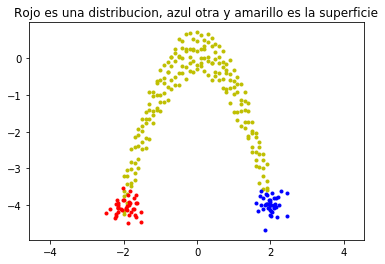

In [589]:
puntos=40

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([2,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-2,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

In [590]:
data=np.concatenate((Zcol,Ycol,W),axis=0)

samples=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones.
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha=2
k=5
dimension=2
f_dist,tree=fermat_graph(data,alpha=alpha)

def my_fermat_cost(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension,f_dist,tree,data,k,alpha)

llamo al baricentro

In [620]:
def prueba(g):

    n_iter=1500
    learningrate0=1
    landa0=10
    landamax=1e9
    beta_adapt=0.05


    h=np.std(samples)*1.06*(samples.shape[0]**(-1/5))
    h=np.std(data)*1.06*(data.shape[0]**(-1/5))
    h=g
    #h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!


    #cost_function=euclidean_cost_fast
    cost_function=my_fermat_cost

    yinit=samples
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001

    return barycenter(yinit,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,categorical=True,callback=False)

In [621]:
def plot(bari,g):
    if cost_function==my_fermat_cost:
        plt.plot(W[:,0],W[:,1],'.',c='y')
    plt.plot(x1,x2,'.',c='r')
    plt.plot(y1,y2,'.',c='b')
    plt.plot(bari[:puntos,0],bari[:puntos,1],'x',c='r')
    plt.plot(bari[puntos:,0],bari[puntos:,1],'x',c='b')
    plt.axis('equal')
    plt.title('h='+str(g))
    plt.show()

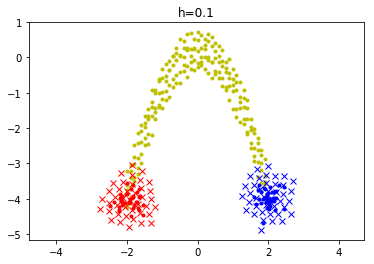

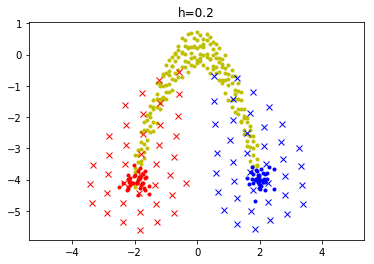

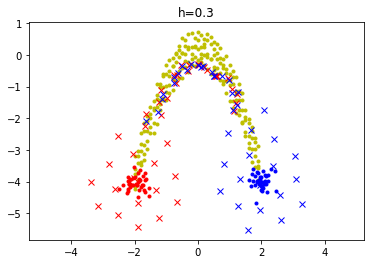

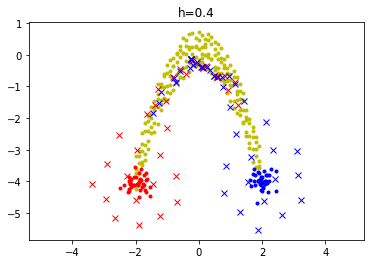

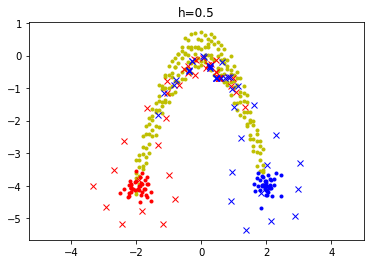

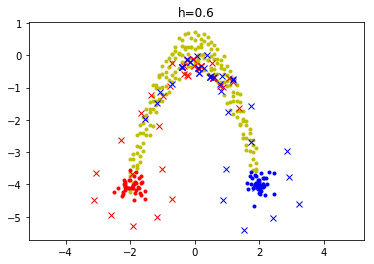

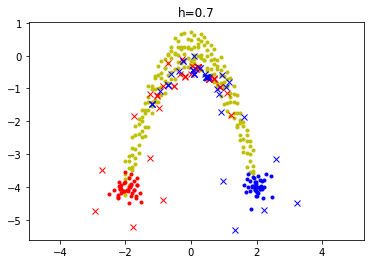

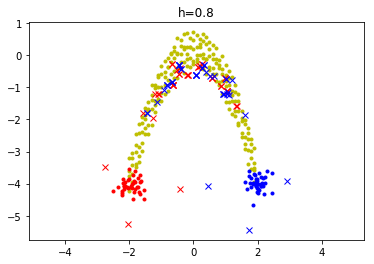

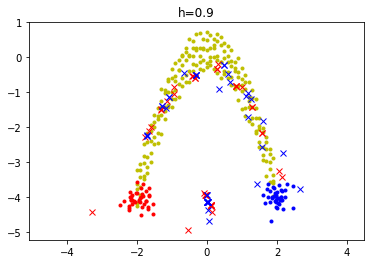

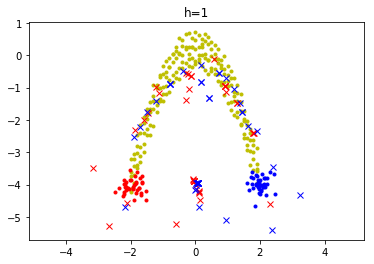

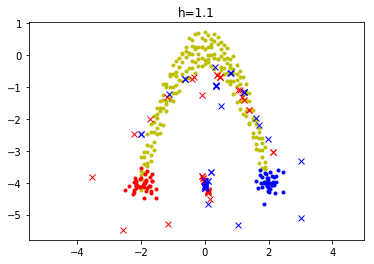

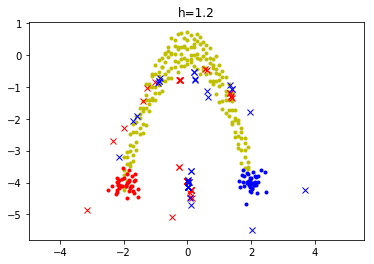

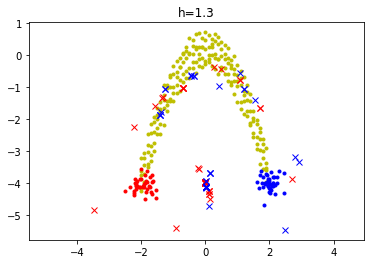

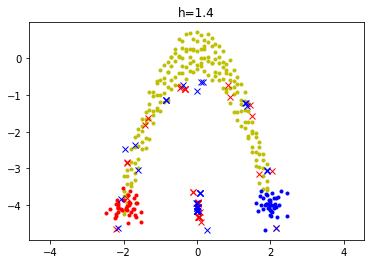

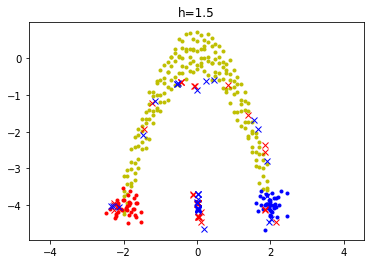

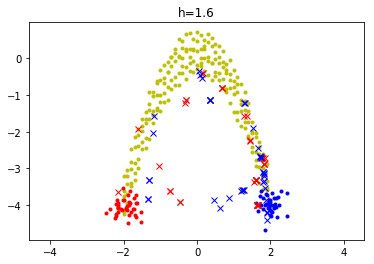

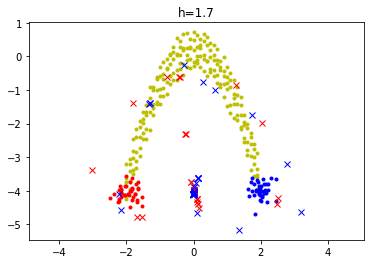

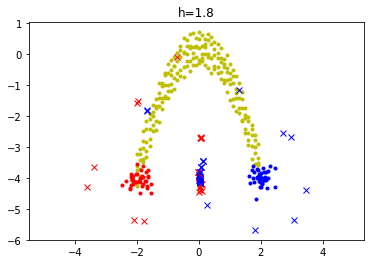

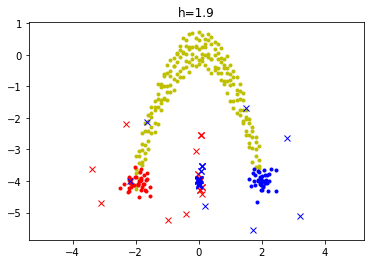

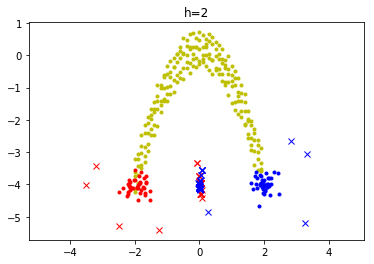

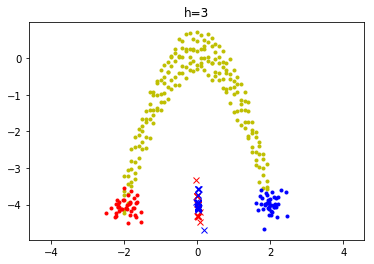

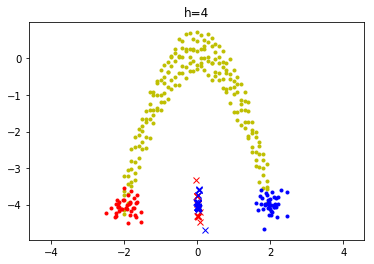

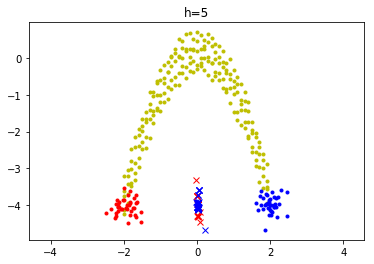

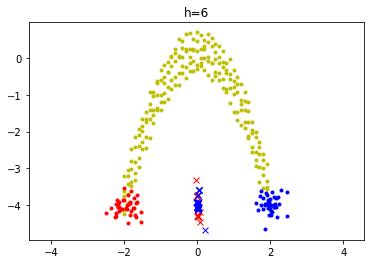

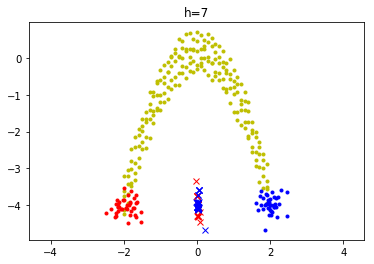

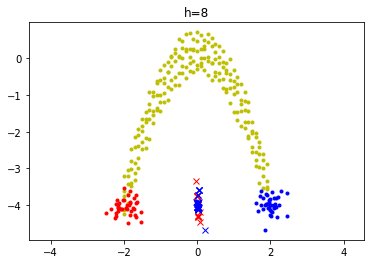

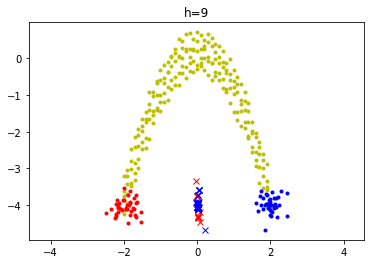

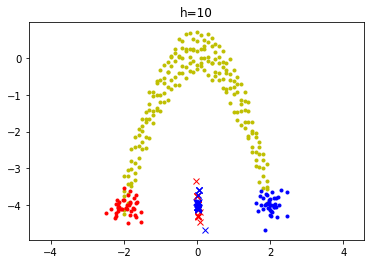

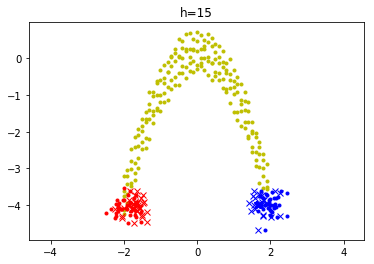

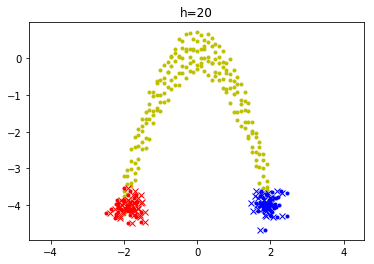

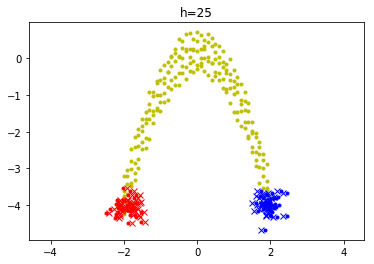

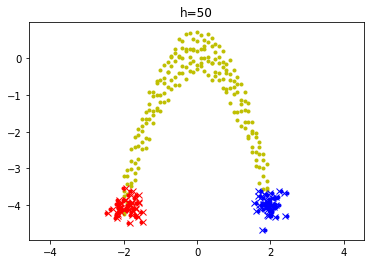

In [622]:
for g in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,3,4,5,6,7,8,9,10,15,20,25,50]:
    plot(prueba(g),g)

-El h adaptativo achica mucho mas rapido la varianza!! Pero favorece tener outliers, si se me juntan varios puntos y unos quedan muy lejos, el h será muy chicos y estos puntos alejados no van a tener en cuenta a los otros.

-Los puntos se empiezana expandir para mejorar al principio, como despues pasa que los que se alejan hacia afuera se vienen al baricentro? Por qué pasaria? Ahi juega muy fuertemente la eleccion del h

-Cuan adaptativo elijo el beta (alpha del paper)? Cuan dependiente del caso e esto? hacer un adaptativo on 0.01 o 0.05 parece andar bien. Todo indicaria que cuanto mas leve el aumento de landa mejor.

-landa max??

-landa0, es muy relevante? Arranca igual si tomo uno muy chico.


### A implementar

Ir con un bandwith muy grande e ir achicandolo. NO pasarse de la rule of thumb, no pasarse de la del principio o ir actualizando!!No tenes que irse con el bandwidth muy chico, sensible a outliers. Recocido simulado de agrandar el h de la nada por si se te escapo algo?

Actualizacion del lambda? Tiene que ir creciendo necesariamente?

Dejar kernels gaussianos pero evaluarlos en la distancia de fermat! EL gradietne hay que actualizarlo tambien con el gradiente de fermat. ESo haria que los puntos se muevan siguiendo la geodesica (pesada por la densidad)

Rellenar el espacio con poca densidad de fermat y que gradualmente vaya aumentando hacia la misma sueprficie

Ver el tema del h

Ejemplo no singular de densidad

enchufar fermat en donde estan los kernels.

Ejemplos distintos: una curva menos pronunciada, otro ejemplo tipo el circulo? Una curva mas separada para afuera

In [478]:
n_iter=300
learningrate0=1
landa0=5
landamax=1e6
beta_adapt=0.01


h=np.std(samples)*1.06*(samples.shape[0]**(-1/5))
h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!

#cost_function=euclidean_cost_fast
cost_function=my_fermat_cost

yinit=samples
#yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
bari=barycenter(yinit,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,categorical=True,callback=True)

it: 0, paso: 0.11291868536353089, landa: 5
it: 1, paso: 0.11265723887466263, landa: 5
it: 2, paso: 0.11196631194976289, landa: 5
it: 3, paso: 0.11046039114681697, landa: 5
it: 4, paso: 0.1077952971278097, landa: 5
it: 5, paso: 0.10371830843803778, landa: 5
it: 6, paso: 0.09821351958104203, landa: 5
it: 7, paso: 0.09197014211572002, landa: 5
it: 8, paso: 0.08570350160359431, landa: 5
it: 9, paso: 0.07917358961084779, landa: 5
it: 10, paso: 0.0741135863470419, landa: 5
it: 11, paso: 0.06814926113758657, landa: 5
it: 12, paso: 0.06136250178998879, landa: 5
it: 13, paso: 0.05619652930962277, landa: 5
it: 14, paso: 0.05207681625060547, landa: 5
it: 15, paso: 0.05131434414913862, landa: 5
it: 16, paso: 0.05282644253879147, landa: 5
it: 17, paso: 0.04816827117203381, landa: 5
it: 18, paso: 0.049754572021026046, landa: 5
it: 19, paso: 0.0456832316922788, landa: 5
it: 20, paso: 0.04192055567321509, landa: 5
it: 21, paso: 0.03986510264566419, landa: 5
it: 22, paso: 0.03818608767736194, landa: 5


it: 180, paso: 1.331967152805313e-16, landa: 5
it: 181, paso: 1.3386269885693392e-16, landa: 5
it: 182, paso: 1.3453201235121859e-16, landa: 5
it: 183, paso: 1.3520467241297467e-16, landa: 5
it: 184, paso: 1.3588069577503952e-16, landa: 5
it: 185, paso: 1.365600992539147e-16, landa: 5
it: 186, paso: 1.3724289975018428e-16, landa: 5
it: 187, paso: 1.3792911424893516e-16, landa: 5
it: 188, paso: 1.3861875982017982e-16, landa: 5
it: 189, paso: 1.393118536192807e-16, landa: 5
it: 190, paso: 1.400084128873771e-16, landa: 5
it: 191, paso: 1.4070845495181396e-16, landa: 5
it: 192, paso: 1.4141199722657302e-16, landa: 5
it: 193, paso: 1.4211905721270588e-16, landa: 5
it: 194, paso: 1.4282965249876939e-16, landa: 5
it: 195, paso: 1.4354380076126322e-16, landa: 5
it: 196, paso: 1.442615197650695e-16, landa: 5
it: 197, paso: 1.4498282736389484e-16, landa: 5
it: 198, paso: 1.4570774150071429e-16, landa: 5
it: 199, paso: 1.4643628020821784e-16, landa: 5
it: 200, paso: 1.471684616092589e-16, landa: 

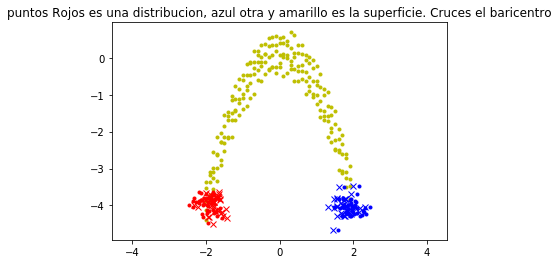

In [479]:
if cost_function==my_fermat_cost:
    plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(bari[:puntos,0],bari[:puntos,1],'x',c='r')
plt.plot(bari[puntos:,0],bari[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

In [296]:
a1=np.random.random((30,2))+[5,5]
a2=np.random.random((30,2))-[5,5]
a3=np.random.random((30,2))+[5,-5]
samples=np.concatenate((a1,a2,a3),axis=0)

z=np.matrix([0 for i in range(30)]+[1 for i in range(30)]+[2 for i in range(30)]).T

In [332]:
n_iter=1000
learningrate0=1
landa0=10
landamax=1e10
beta_adapt=0.01


h=np.std(samples)*1.06*(samples.shape[0]**(-1/5))
#h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!

cost_function=euclidean_cost_fast
#cost_function=my_fermat_cost

yinit=samples
#yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
bari=barycenter(yinit,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,categorical=True,callback=True)

it: 0, paso: 0.797609236698217, landa: 10
it: 1, paso: 0.016023068337625058, landa: 17.044092111160325
it: 2, paso: 0.018226356992280427, landa: 17.28269923832222
it: 3, paso: 0.017445947883589108, landa: 17.576866780323808
it: 4, paso: 0.01709353416601319, landa: 17.871792790188824
it: 5, paso: 0.017241694484087557, landa: 18.17296785627721
it: 6, paso: 0.017413738739095286, landa: 18.476975339703984
it: 7, paso: 0.017743895011101796, landa: 18.78620440445856
it: 8, paso: 0.018051154043223775, landa: 19.099119694959995
it: 9, paso: 0.018416885099867632, landa: 19.416812516439975
it: 10, paso: 0.018769262864733224, landa: 19.738622470618346
it: 11, paso: 0.01914830689313101, landa: 20.065047747822444
it: 12, paso: 0.019524618778767298, landa: 20.3958239578455
it: 13, paso: 0.019916230624959414, landa: 20.731184884482428
it: 14, paso: 0.0203110906411184, landa: 21.071040551325044
it: 15, paso: 0.02071697853283572, landa: 21.415509840350776
it: 16, paso: 0.021129063649102244, landa: 21.7

it: 143, paso: 0.0915433090646809, landa: 110.32539054014926
it: 144, paso: 0.0925162309787339, landa: 111.42259311310022
it: 145, paso: 0.09349935968388191, landa: 112.53991955924685
it: 146, paso: 0.09449268014818507, landa: 113.67795553150991
it: 147, paso: 0.09549615597452626, landa: 114.83730739345154
it: 148, paso: 0.09650972734729528, landa: 116.01860310341955
it: 149, paso: 0.09753330914083075, landa: 117.22249314336995
it: 150, paso: 0.0985667892789647, landa: 118.44965149357644
it: 151, paso: 0.09961002744590519, landa: 119.7007766541189
it: 152, paso: 0.10066285425796999, landa: 120.97659271366727
it: 153, paso: 0.10172507101260438, landa: 122.27785046564742
it: 154, paso: 0.10279645013469882, landa: 123.6053285713953
it: 155, paso: 0.10387673643937899, landa: 124.95983476938822
it: 156, paso: 0.1049656493242671, landa: 126.3422071290979
it: 157, paso: 0.106062885991867, landa: 127.75331534746302
it: 158, paso: 0.10716812578334092, landa: 129.19406208544746
it: 159, paso: 0.

it: 278, paso: 0.09309373149736487, landa: 388.3477876757492
it: 279, paso: 0.09460092888889374, landa: 391.98851042565883
it: 280, paso: 0.09616859454097611, landa: 395.68126931298843
it: 281, paso: 0.09779767836569071, landa: 399.4261163005788
it: 282, paso: 0.09948863240898186, landa: 403.2230530039025
it: 283, paso: 0.10124134129771786, landa: 407.0720323160316
it: 284, paso: 0.10305506391159466, landa: 410.97296102531925
it: 285, paso: 0.10492839208982337, landa: 414.9257034443141
it: 286, paso: 0.10685923231614645, landa: 418.9300860216414
it: 287, paso: 0.10884481591694166, landa: 422.98590285560124
it: 288, paso: 0.11088174224381127, landa: 427.0929219732166
it: 289, paso: 0.11296605753784493, landa: 431.25089218719256
it: 290, paso: 0.11509336970814696, landa: 435.4595503028003
it: 291, paso: 0.11725899620878055, landa: 439.718628424874
it: 292, paso: 0.11945813874989533, landa: 444.02786111958034
it: 293, paso: 0.12168607496559099, landa: 448.38699222303177
it: 294, paso: 0.1

it: 419, paso: 0.23426399594247527, landa: 2289.6955508532515
it: 420, paso: 0.38387986912782024, landa: 2293.034440801939
it: 421, paso: 0.2518753656744667, landa: 2309.4080003913487
it: 422, paso: 0.4042295577997138, landa: 2312.8636183874596
it: 423, paso: 0.15114348938136546, landa: 2328.334445932713
it: 424, paso: 0.176345788970945, landa: 2332.007380559259
it: 425, paso: 0.34777646165442383, landa: 2339.4866333129885
it: 426, paso: 0.37570725716238623, landa: 2356.009189978407
it: 427, paso: 0.248468909789651, landa: 2368.3369297112968
it: 428, paso: 0.22233179670294678, landa: 2377.2734746077795
it: 429, paso: 0.4133017483565814, landa: 2384.329115707544
it: 430, paso: 0.16639691339238913, landa: 2399.5387504799114
it: 431, paso: 0.1825782442288032, landa: 2404.192100451337
it: 432, paso: 0.3687583923705768, landa: 2413.5876997669247
it: 433, paso: 0.7767504532775782, landa: 2432.0045828462294
it: 434, paso: 0.21622615328976774, landa: 2459.617863925465
it: 435, paso: 0.18591173

it: 555, paso: 0.08822218775355709, landa: 3969.7975624201777
it: 556, paso: 0.12198962998414345, landa: 3978.081384065615
it: 557, paso: 0.24900885637796036, landa: 3993.483789167741
it: 558, paso: 0.14166898304326425, landa: 4016.621590761256
it: 559, paso: 0.15287312646775947, landa: 4023.416672048468
it: 560, paso: 0.08597987702494216, landa: 4030.6861594489883
it: 561, paso: 0.12720788114285583, landa: 4038.002438096324
it: 562, paso: 0.2605100276134708, landa: 4053.2529346747547
it: 563, paso: 0.08373690652985427, landa: 4074.846708351002
it: 564, paso: 0.1302411006779844, landa: 4081.1088588927605
it: 565, paso: 0.2669275898980498, landa: 4094.5526786472215
it: 566, paso: 0.0930950314571229, landa: 4115.382776221732
it: 567, paso: 0.13398957790616742, landa: 4121.104783344446
it: 568, paso: 0.28167115469637644, landa: 4135.972766838997
it: 569, paso: 0.12503761363851135, landa: 4147.616286328201
it: 570, paso: 0.14383842830514776, landa: 4154.821445825491
it: 571, paso: 0.165034

it: 695, paso: 0.05128637188392023, landa: 5999.732775559064
it: 696, paso: 0.07244655480449601, landa: 6012.0739144614645
it: 697, paso: 0.14722885665939714, landa: 6036.3417071370395
it: 698, paso: 0.3013634913499497, landa: 6075.664769680165
it: 699, paso: 0.09977937374305498, landa: 6132.811816149666
it: 700, paso: 0.053668499661089226, landa: 6132.811816149666
it: 701, paso: 0.07589894510871954, landa: 6145.806481294727
it: 702, paso: 0.15396914439003045, landa: 6168.2287334659
it: 703, paso: 0.16617546210924433, landa: 6206.829410770615
it: 704, paso: 0.06516472304886511, landa: 6215.730261925344
it: 705, paso: 0.07856636239512862, landa: 6228.913323333875
it: 706, paso: 0.16085566773397234, landa: 6253.236563592191
it: 707, paso: 0.10423597074966852, landa: 6289.526099663744
it: 708, paso: 0.0602568967612693, landa: 6289.526099663744
it: 709, paso: 0.08082216547011903, landa: 6303.582346229139
it: 710, paso: 0.1663972342476174, landa: 6327.505678144083
it: 711, paso: 0.059036605

it: 831, paso: 0.06426184842290539, landa: 8287.21623372176
it: 832, paso: 0.10129821123803702, landa: 8287.21623372176
it: 833, paso: 0.03645347184111093, landa: 8297.258639496884
it: 834, paso: 0.044971398538074026, landa: 8312.174398638772
it: 835, paso: 0.08867094809584464, landa: 8331.817037333038
it: 836, paso: 0.18931363906459311, landa: 8367.39123967765
it: 837, paso: 0.050640810056045454, landa: 8367.39123967765
it: 838, paso: 0.047498399195746666, landa: 8388.89355455854
it: 839, paso: 0.09239509125563504, landa: 8408.997627895511
it: 840, paso: 0.10407416656667819, landa: 8435.085833589164
it: 841, paso: 0.03773474003302483, landa: 8435.085833589164
it: 842, paso: 0.04647411052147797, landa: 8446.108782747957
it: 843, paso: 0.0927741098254831, landa: 8464.981979262791
it: 844, paso: 0.19708459850622173, landa: 8499.713495389744
it: 845, paso: 0.05363584127058047, landa: 8499.713495389744
it: 846, paso: 0.048246154811872326, landa: 8522.766153887029
it: 847, paso: 0.095929724

it: 968, paso: 0.03433070643692306, landa: 11810.237433282822
it: 969, paso: 0.051849470120750904, landa: 11818.204009303037
it: 970, paso: 0.1062039029179583, landa: 11844.806106565047
it: 971, paso: 0.03510050112065692, landa: 11854.307736262788
it: 972, paso: 0.05323811332425555, landa: 11865.896591862323
it: 973, paso: 0.10949579349598534, landa: 11887.338360443882
it: 974, paso: 0.039196893805877424, landa: 11891.696872239778
it: 975, paso: 0.0548858416336535, landa: 11891.696872239778
it: 976, paso: 0.11508274792743911, landa: 11920.233057048568
it: 977, paso: 0.04957925852112921, landa: 11920.233057048568
it: 978, paso: 0.0583909420646833, landa: 11932.796055019238
it: 979, paso: 0.06400400065115998, landa: 11939.67348606561
it: 980, paso: 0.03788232616460709, landa: 11939.67348606561
it: 981, paso: 0.056890823652612235, landa: 11945.173771782233
it: 982, paso: 0.12071674904619197, landa: 11974.395631817802
it: 983, paso: 0.028711077855619202, landa: 11974.395631817802
it: 984, 

it: 1104, paso: 0.032884149470350156, landa: 15898.044337300633
it: 1105, paso: 0.055450744171244265, landa: 15917.16177260724
it: 1106, paso: 0.020987339661367194, landa: 15917.16177260724
it: 1107, paso: 0.02437616662064112, landa: 15958.343134624092
it: 1108, paso: 0.04863680657590835, landa: 16008.562990697505
it: 1109, paso: 0.10520248196714148, landa: 16085.775976196022
it: 1110, paso: 0.030990514237622935, landa: 16085.775976196022
it: 1111, paso: 0.026067732580322977, landa: 16113.887439840006
it: 1112, paso: 0.051526798062166264, landa: 16154.185918206644
it: 1113, paso: 0.05924904231947752, landa: 16228.837541252955
it: 1114, paso: 0.02281036343326053, landa: 16228.837541252955
it: 1115, paso: 0.02638684915269158, landa: 16259.868125965886
it: 1116, paso: 0.05316559693628754, landa: 16299.29274642979
it: 1117, paso: 0.11338381779424281, landa: 16358.55016830745
it: 1118, paso: 0.031676421253597556, landa: 16358.55016830745
it: 1119, paso: 0.02785059586753835, landa: 16374.583

it: 1238, paso: 0.10533246518086033, landa: 19875.567139590865
it: 1239, paso: 0.026767968445236514, landa: 19875.567139590865
it: 1240, paso: 0.025764159140340356, landa: 19893.362609045882
it: 1241, paso: 0.0522639953000602, landa: 19956.11927782122
it: 1242, paso: 0.058759093792212044, landa: 20046.02132472141
it: 1243, paso: 0.026328024980010682, landa: 20046.02132472141
it: 1244, paso: 0.026690136951313913, landa: 20063.116697375033
it: 1245, paso: 0.05433402949396987, landa: 20118.443782296636
it: 1246, paso: 0.033738433477147, landa: 20175.31418165546
it: 1247, paso: 0.018667776697936646, landa: 20175.31418165546
it: 1248, paso: 0.027153390487678085, landa: 20197.730117048115
it: 1249, paso: 0.0551253217060166, landa: 20251.95228469968
it: 1250, paso: 0.032011052557799194, landa: 20321.546818093648
it: 1251, paso: 0.035149640036104206, landa: 20321.546818093648
it: 1252, paso: 0.02013303107690432, landa: 20321.546818093648
it: 1253, paso: 0.028161949763892434, landa: 20351.63152

it: 1374, paso: 0.025548547904677723, landa: 22901.530336994
it: 1375, paso: 0.03409331789489684, landa: 22901.530336994
it: 1376, paso: 0.0711464916007462, landa: 22901.530336994
it: 1377, paso: 0.02937664057670557, landa: 22901.530336994
it: 1378, paso: 0.03605953855551667, landa: 22901.530336994
it: 1379, paso: 0.07685428256605337, landa: 22901.530336994
it: 1380, paso: 0.03744137314526369, landa: 22901.530336994
it: 1381, paso: 0.03926308185398639, landa: 22901.530336994
it: 1382, paso: 0.04391434784308238, landa: 22901.530336994
it: 1383, paso: 0.02648455500878491, landa: 22901.530336994
it: 1384, paso: 0.03815887845992782, landa: 22901.530336994
it: 1385, paso: 0.08096518271387451, landa: 22901.530336994
it: 1386, paso: 0.03825886328641676, landa: 22901.530336994
it: 1387, paso: 0.042639840007223526, landa: 22901.530336994
it: 1388, paso: 0.04909178353285273, landa: 22901.530336994
it: 1389, paso: 0.03120541856267699, landa: 22901.530336994
it: 1390, paso: 0.04203460466950014, la

it: 1514, paso: 0.029611398742858806, landa: 26803.070100073244
it: 1515, paso: 0.017429977163443643, landa: 26926.76065161581
it: 1516, paso: 0.028999539880761573, landa: 26998.84506225044
it: 1517, paso: 0.0328746674806578, landa: 27146.62495957026
it: 1518, paso: 0.02201364693568615, landa: 27146.62495957026
it: 1519, paso: 0.03178479025441901, landa: 27173.498607822374
it: 1520, paso: 0.020907424111592705, landa: 27244.093002392532
it: 1521, paso: 0.03148523812437033, landa: 27288.6898982914
it: 1522, paso: 0.02070037080883197, landa: 27384.132362219043
it: 1523, paso: 0.03177728924681121, landa: 27432.44381201702
it: 1524, paso: 0.021325461957724036, landa: 27524.525034191727
it: 1525, paso: 0.03264523666072023, landa: 27565.527544828325
it: 1526, paso: 0.02289404880092948, landa: 27630.75661946941
it: 1527, paso: 0.01713229765515421, landa: 27652.828200874574
it: 1528, paso: 0.030109997890028734, landa: 27763.90964208478
it: 1529, paso: 0.018817294067236992, landa: 27948.28797284

it: 1648, paso: 0.01628208145942637, landa: 36327.83280661169
it: 1649, paso: 0.0328891337757444, landa: 36327.83280661169
it: 1650, paso: 0.06828672878749553, landa: 36327.83280661169
it: 1651, paso: 0.015009715653843828, landa: 36327.83280661169
it: 1652, paso: 0.01732772561316716, landa: 36327.83280661169
it: 1653, paso: 0.035042188736798666, landa: 36327.83280661169
it: 1654, paso: 0.07200205532384309, landa: 36327.83280661169
it: 1655, paso: 0.02554639490437172, landa: 36327.83280661169
it: 1656, paso: 0.025270315508500073, landa: 36327.83280661169
it: 1657, paso: 0.02514130431208237, landa: 36327.83280661169
it: 1658, paso: 0.02514175007907994, landa: 36327.83280661169
it: 1659, paso: 0.025260422966337414, landa: 36327.83280661169
it: 1660, paso: 0.025491798523119943, landa: 36327.83280661169
it: 1661, paso: 0.025835737333493144, landa: 36327.83280661169
it: 1662, paso: 0.02629735866295583, landa: 36327.83280661169
it: 1663, paso: 0.026887595758812284, landa: 36327.83280661169
it

it: 1784, paso: 0.06581532845565356, landa: 36327.83280661169
it: 1785, paso: 0.026733000253077305, landa: 36327.83280661169
it: 1786, paso: 0.029672638624032965, landa: 36327.83280661169
it: 1787, paso: 0.06007469891060626, landa: 36327.83280661169
it: 1788, paso: 0.12484772472908248, landa: 36327.83280661169
it: 1789, paso: 0.02639812525042451, landa: 36327.83280661169
it: 1790, paso: 0.03190244905785929, landa: 36327.83280661169
it: 1791, paso: 0.0645328937154343, landa: 36327.83280661169
it: 1792, paso: 0.1322723068602031, landa: 36327.83280661169
it: 1793, paso: 0.04449290012341823, landa: 36327.83280661169
it: 1794, paso: 0.04410894669387975, landa: 36327.83280661169
it: 1795, paso: 0.043940488481005374, landa: 36327.83280661169
it: 1796, paso: 0.043960763821239826, landa: 36327.83280661169
it: 1797, paso: 0.04415313556909983, landa: 36327.83280661169
it: 1798, paso: 0.04451143601475424, landa: 36327.83280661169
it: 1799, paso: 0.045037902381494056, landa: 36327.83280661169
it: 1

it: 1918, paso: 0.01645718598975523, landa: 50776.16199093264
it: 1919, paso: 0.009860611458081946, landa: 50837.115168290555
it: 1920, paso: 0.014563187931239044, landa: 50970.17900322031
it: 1921, paso: 0.015626229357427895, landa: 51292.229977396906
it: 1922, paso: 0.009013216409555524, landa: 51482.27702077251
it: 1923, paso: 0.01473086951128668, landa: 51621.2707774331
it: 1924, paso: 0.03143549062058619, landa: 51943.31329938336
it: 1925, paso: 0.007896235696251279, landa: 51943.31329938336
it: 1926, paso: 0.008507843708690425, landa: 52162.725281842606
it: 1927, paso: 0.014933589432365188, landa: 52330.783523112834
it: 1928, paso: 0.03184409697096878, landa: 52673.567935940264
it: 1929, paso: 0.00801397592328255, landa: 52673.567935940264
it: 1930, paso: 0.008499576106391417, landa: 52902.17668679839
it: 1931, paso: 0.015296164801380121, landa: 53071.80632020864
it: 1932, paso: 0.0165144905875882, landa: 53421.71849377641
it: 1933, paso: 0.01000264831715158, landa: 53573.1029891

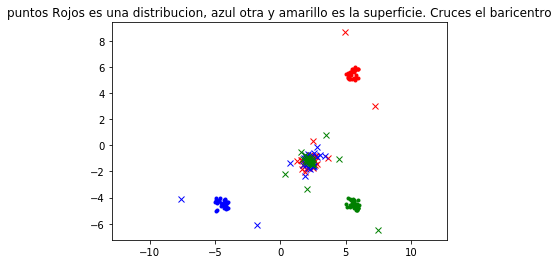

In [333]:
if cost_function==my_fermat_cost:
    plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(a1[:,0],a1[:,1],'.',c='r')
plt.plot(a2[:,0],a2[:,1],'.',c='b')
plt.plot(a3[:,0],a3[:,1],'.',c='g')
plt.plot(bari[:30,0],bari[:30,1],'x',c='r')
plt.plot(bari[30:60,0],bari[30:60,1],'x',c='b')
plt.plot(bari[60:,0],bari[60:,1],'x',c='g')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()